# Attemp to use random forest to predict Prot

In [3]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

# Read and merge data from Kepler and Gaia

Kepler-Gaia crossmatch data from https://gaia-kepler.fun

In [4]:
# read in data
data = pd.read_csv("VizieR4041Flare.csv") 
print(data.dtypes)
# drop rows with NaNs
data=data.dropna()

KIC            int64
g_i          float64
Mass         float64
Prot         float64
Nfl            int64
Nfl68          int64
Lfl_Lkp      float64
e_Lfl_Lkp    float64
alpha        float64
beta         float64
M14            int64
C16            int64
_RA          float64
_DE          float64
dtype: object


In [20]:
import astropy.utils as au
from astropy.io import fits

with fits.open('kepler_dr2_1arcsec.fits') as data_ga:
    #data_ga.info()
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#df = pd.merge(mc, gaia, left_on="KID", right_on="kepid", how="inner")

In [21]:
# just to print out all the columns 
for col in gaia.columns: 
    print(col) 

solution_id
designation
source_id
random_index
gaia_ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_flux_over_error
phot_g_mean_mag
phot_bp_n_obs
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_flux_over_error
phot_bp_me

In [158]:
# merge two tables
df = pd.merge(data, gaia, left_on="KIC", right_on="kepid", how="inner")

# Random Forest

In [183]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize

# random forest function
def my_randF(df,traind):
    # other features: R35, R1s? 
    # df: the data
    # traind: what fraction of data use to train
    
    # number the features with dictionary
    fl=len(df.columns) # how many features
    keys=range(fl)
    flib=dict(zip(keys, df.columns))

    featl=len(df.Prot) # feature length

    # initalize feature array
    X=np.zeros([featl,fl])

    actrualF=[] # actrual feature used
    # fill in feature array
    for i in range(1,fl):
        feature=df.iloc[:,i]
        # if input not string, not Prot and no NaN
        if (type(feature[0]) is not str) and (flib[i]!='Prot') and (not np.isnan(feature).any()):
            X[:,i]=feature
            actrualF.append(flib[i])

    # initalize normalized factor
    X_normalized = normalize(X, norm='l2')
    
    # output
    y=np.array(df.Prot)

    # run random forest
    regr = RandomForestRegressor(random_state=0,n_estimators=1000)
    regr.fit(X[0:int(traind*featl),:], y[0:int(traind*featl)])  

    # get the importance of each feature
    importance=regr.feature_importances_
    
    return regr,importance

# Using 70% data as training set
traind=0.7
regr,importance=my_randF(df,traind)  

# Some analysis of result

Text(0.5, 0, 'Prediction number')

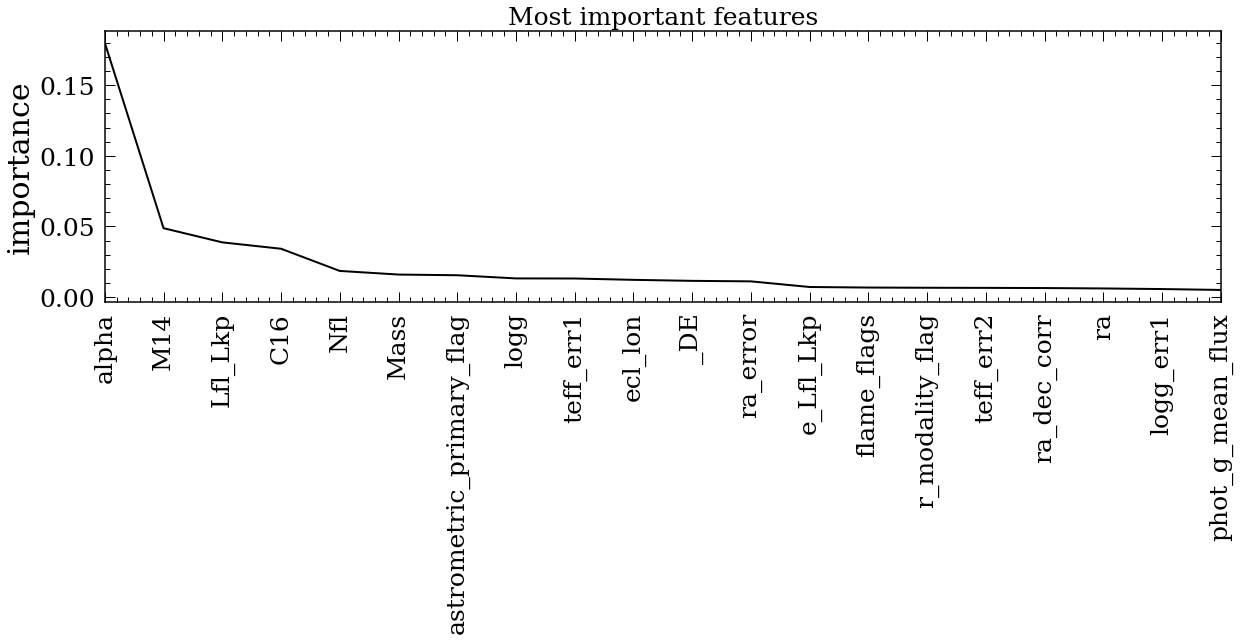

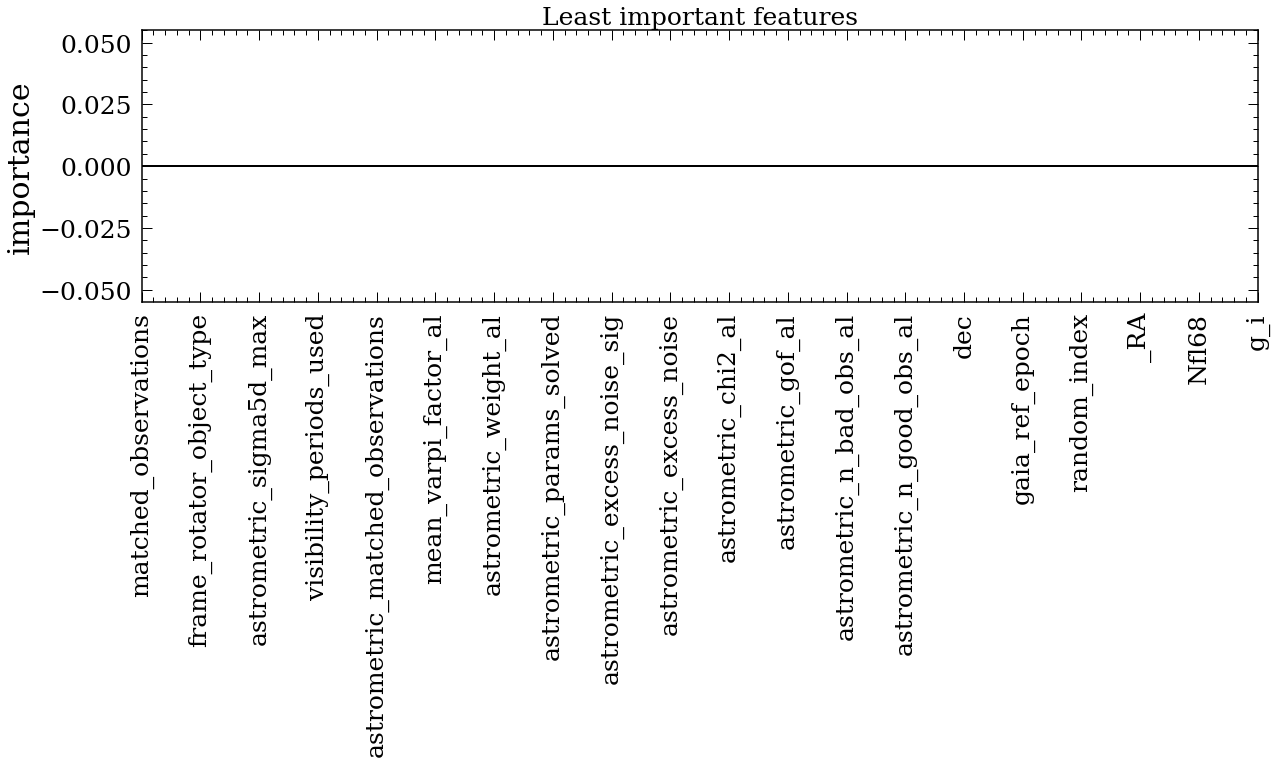

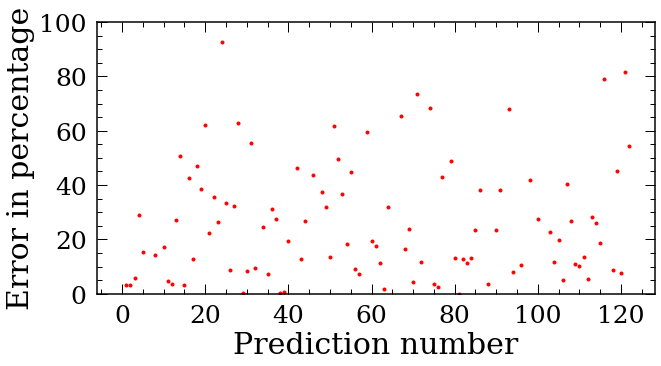

In [169]:
# zip the importance with its feature name
list1 = list(zip(actrualF,importance))
# sort the zipped list
decend=sorted(list1, key=lambda x:x[1])

# how many features to plot
topn=20 
x=range(topn)


####################  get most important features ############################################################
# get index and value for y
y_val=[decend[i][1] for i in range(len(decend)-topn,len(decend))]
my_xticks=[decend[i][0] for i in range(len(decend)-topn,len(decend))]

plt.figure(figsize=(20,5))
plt.title('Most important features',fontsize=25)
plt.xticks(x, my_xticks)
plt.plot(x, y_val,'k-')
plt.xlim([max(x),min(x)])
plt.xticks(rotation=90)
plt.ylabel('importance')
####################  get most important features ############################################################


####################  get least important features ############################################################
# get index and value for y
y_val=[decend[i][1] for i in range(topn)]
my_xticks=[decend[i][0] for i in range(topn)]

plt.figure(figsize=(20,5))
plt.title('Least important features',fontsize=25)
plt.xticks(x, my_xticks)
plt.plot(x, y_val,'k-')
plt.xlim([max(x),min(x)])
plt.xticks(rotation=90)
plt.ylabel('importance')
####################  get least important features ############################################################

# test... could probbaly put this part in my_randF function
diff=np.zeros([len(range(int(traind*featl)+1,featl)),1])
difc=0
for i in range(int(traind*featl)+1,featl):
    diff[difc]=abs((regr.predict([X[i,:]])-y[i])/y[i])*100
    difc=difc+1
    
plt.figure(figsize=(10,5))
plt.plot(diff,'r.')
plt.ylim([0,100])
plt.ylabel('Error in percentage')
plt.xlabel('Prediction number')

# Testing using different fraction of data as training set

In [180]:
fraci=[0.1+0.1*i for i in range(8)] # fraction list
average_e=np.zeros([len(fraci),1])
counte=0
for i in fraci:
    print(i)
    regr,importance=my_randF(df,i)  
    diff=np.zeros([len(range(int(traind*i)+1,featl)),1])
    difc=0
    for j in range(int(traind*i)+1,featl):
        diff[difc]=abs((regr.predict([X[j,:]])-y[j])/y[j])*100
        difc=difc+1
    average_e[counte]=np.median(diff)
    counte=counte+1

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8


Text(0.5, 0, 'Fraction used as training set')

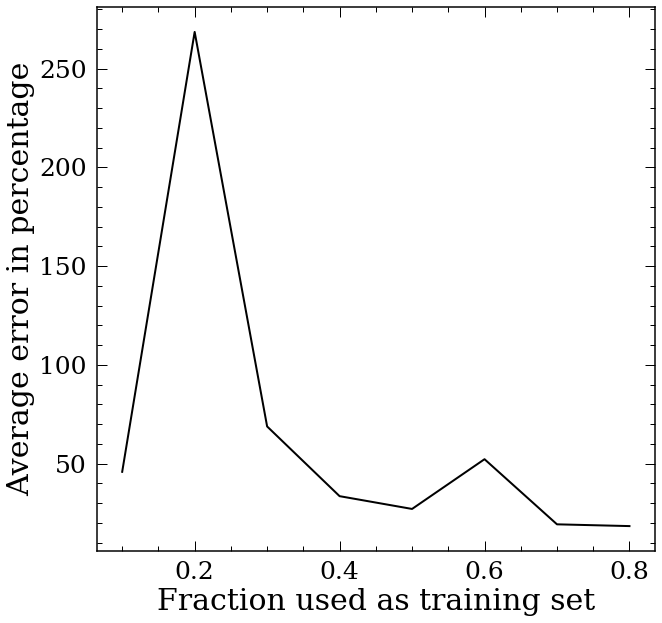

In [182]:
plt.plot(fraci,average_e,'k-')
plt.ylabel('Average error in percentage')
plt.xlabel('Fraction used as training set')